1. Преобразовать данные:  
    a. проверить наличие пропущенных значений. Преобразовать/удалить пропуски по необходимости;  
    b. закодировать категориальные переменные числовыми значениями по необходимости.  
2. Разделить выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.
3. Постройть ROC-кривую с помощью функции sklearn.metrics. roc_curve.
4. Вычислить значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.
5. Реализовать подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
6. Построить ROC-кривую с помощью вычисленных в п. 5 метрик  
7. Построить график Precision-Recall, используя метрики, посчитанные в п. 5.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, roc_auc_score, auc)

#### 1. Предобработка

In [2]:
data = pd.read_csv('./data/athletes.csv')

In [3]:
display(data.head())
display(data.shape)
data.info()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


(11538, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


1. Преобразуем даты к соответствующему формату
2. Получим год рождения
3. Пропуски в росте и весе заполним по медиане групп (национальность + пол)
4. Оставшиеся пропуски после удалим

In [4]:
data['dob'] = pd.to_datetime(data['dob'])
data['dob'] = np.where(data['dob'].dt.year > 2022, data['dob'] - pd.offsets.DateOffset(years=100), data['dob'])
data['year'] = data['dob'].dt.year

In [5]:
pd.concat([data.isnull().sum().rename('cnt'), round((data.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
id,0,0.00
name,0,0.00
nationality,0,0.00
sex,0,0.00
dob,1,0.01
height,330,2.86
weight,659,5.71
sport,0,0.00
gold,0,0.00
silver,0,0.00


In [6]:
data.loc[data['height'].isna(), 'height'] = data.groupby(['nationality', 'sex'])['height'].transform('median')
data.loc[data['weight'].isna(), 'weight'] = data.groupby(['nationality', 'sex'])['weight'].transform('median')
data.dropna(inplace=True)

In [7]:
pd.concat([data.isnull().sum().rename('cnt'), round((data.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
id,0,0.0
name,0,0.0
nationality,0,0.0
sex,0,0.0
dob,0,0.0
height,0,0.0
weight,0,0.0
sport,0,0.0
gold,0,0.0
silver,0,0.0


In [8]:
display(data.head())
display(data.shape)
data.info()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,year
0,736041664,A Jesus Garcia,ESP,male,1969-10-17,1.72,64.0,athletics,0,0,0,1969.0
1,532037425,A Lam Shin,KOR,female,1986-09-23,1.68,56.0,fencing,0,0,0,1986.0
2,435962603,Aaron Brown,CAN,male,1992-05-27,1.98,79.0,athletics,0,0,1,1992.0
3,521041435,Aaron Cook,MDA,male,1991-01-02,1.83,80.0,taekwondo,0,0,0,1991.0
4,33922579,Aaron Gate,NZL,male,1990-11-26,1.81,71.0,cycling,0,0,0,1990.0


(11476, 12)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11476 entries, 0 to 11537
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           11476 non-null  int64         
 1   name         11476 non-null  object        
 2   nationality  11476 non-null  object        
 3   sex          11476 non-null  object        
 4   dob          11476 non-null  datetime64[ns]
 5   height       11476 non-null  float64       
 6   weight       11476 non-null  float64       
 7   sport        11476 non-null  object        
 8   gold         11476 non-null  int64         
 9   silver       11476 non-null  int64         
 10  bronze       11476 non-null  int64         
 11  year         11476 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 1.1+ MB


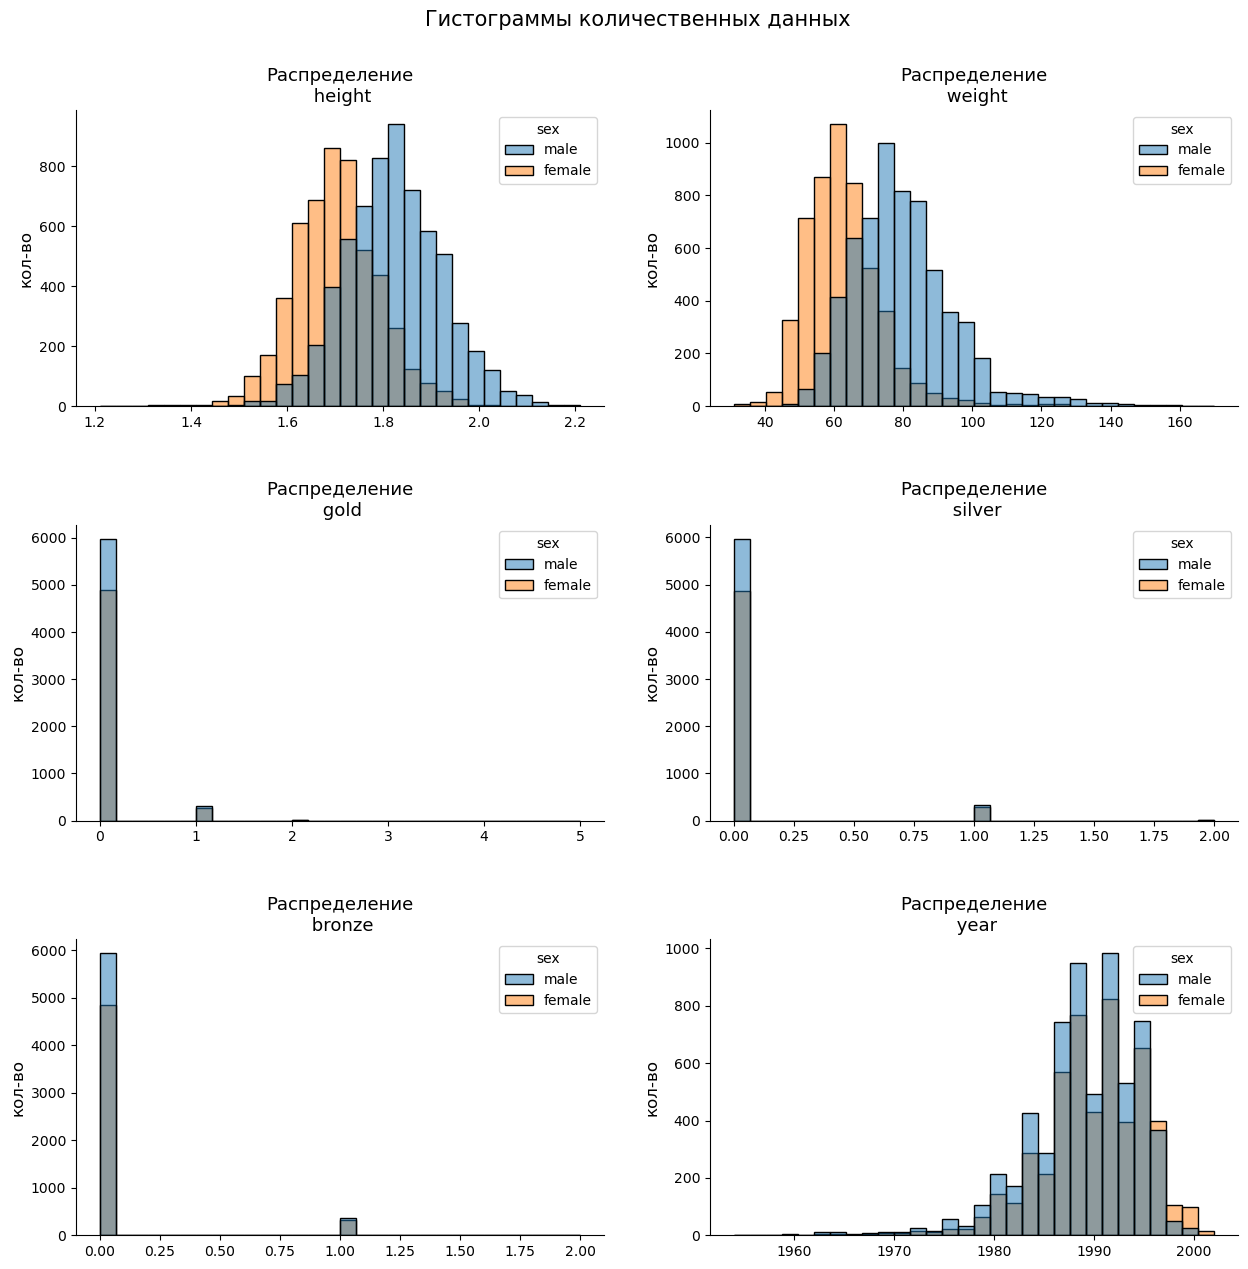

In [9]:
fig = plt.figure(figsize=(15,20))
cols = [k for k,v in data.dtypes.to_dict().items() if v in ['int', 'float'] and k not in ['id']]
for i,col in enumerate(cols):
    fig.add_subplot(4, 2, i+1)
    sns.histplot(data=data, x=col, hue='sex', kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Гистограммы количественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

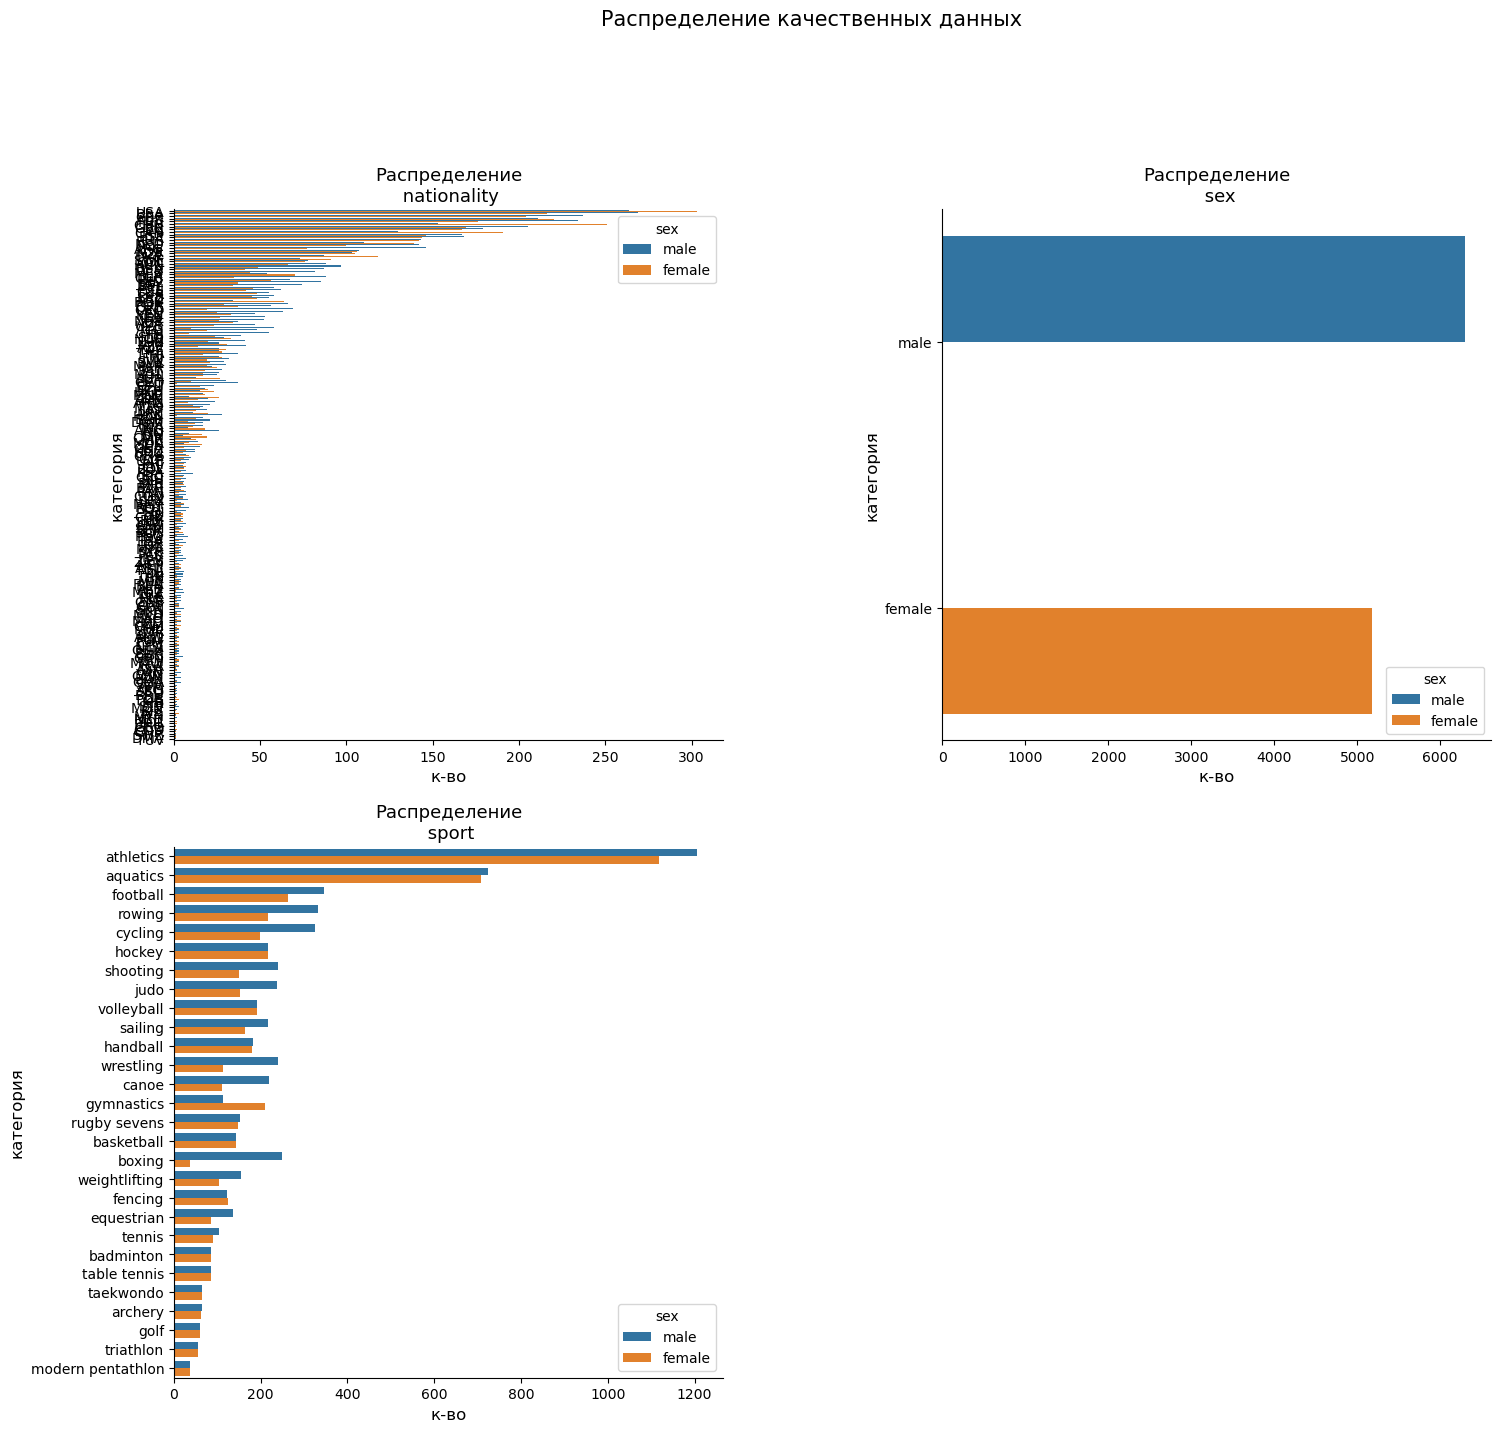

In [10]:
fig = plt.figure(figsize=(17,40))

cols = ['nationality', 'sex', 'sport']
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.countplot(data=data, y=col, order = data[col].value_counts().index, hue='sex', linewidth=1)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('к-во', size=12)
    sns.despine()
    plt.ylabel('категория', size=12)
plt.suptitle('Распределение качественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

<div class="alert alert-danger">
!!! График с национальностями говорит лишь о том что преобразовывать этот признак через `get_dummies` не целесообразно !!!
</div>

#### 2,3,4. Построение модели, график ROC кривой и расчет ROC AUC 

1. Удаляем id, имя, день рождения
2. Спортов не так много, преобразуем через `get_dummies`
3. Национальностей много, преобразуем через `LabelEncoder`

In [11]:
data.drop(columns=['id', 'name','dob'], inplace=True)

In [12]:
data = pd.get_dummies(data=data, columns=['sport']).copy()

In [13]:
data['sex'] = data['sex'].map({'male': 0, 'female': 1})

In [14]:
le = LabelEncoder()

In [15]:
for item in [k for k,v in data.dtypes.to_dict().items() if v == "object"]:
    le.fit(data[item])
    data[item] = le.transform(data[item])

In [16]:
display(data.head())
display(data.shape)
# data.info()

,nationality,sex,height,weight,gold,silver,bronze,year,sport_aquatics,sport_archery,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,59,0,1.72,64.0,0,0,0,1969.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101,1,1.68,56.0,0,0,0,1986.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,0,1.98,79.0,0,0,1,1992.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,117,0,1.83,80.0,0,0,0,1991.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,138,0,1.81,71.0,0,0,0,1990.0,0,0,...,0,0,0,0,0,0,0,0,0,0


(11476, 36)

Эти функции из предыдущего проекта

In [17]:
def make_prediction(m, df, target):
    '''
    ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЙ
    ---------------------------
    На вход подается название модели, датафрейм, название столбца с целевой переменной
    Внутри происходит следующее:
    1) Датафрейм делится на признаки и Целевую переменную
    2) Выборка делится на обучающую и валидационную 80/20
    3) Обучающая выборка z преобразуется (средняя=0, std=1)
    4) Обучаем модель на преобразованной выборке
    5) Выдаем тестовый вектора целевой переменной, предсказаний целевой переменной и accuracy на тренировочной и тестовой выборках
    '''
    y = df[target]
    X = df.drop([target], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    model = m
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    score_train = model.score(X_train_st, y_train)
    y_proba = model.predict_proba(X_test_st)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_auc_score_ = roc_auc_score(y_test, y_proba)
    return y_test, y_pred, y_proba, score_train, threshold, roc_auc_score_, fpr, tpr, roc_auc

In [18]:
def metrics_dict(*data):
    '''
    ФУНКЦИЯ ДЛЯ РАСЧЕТА МЕТРИК
    ---------------------------
    На вход подаются вектора истиной целевой переменной, 
    предсказанной целевой переменной.
    В результате выводятся: Матрица ошибок, Accuracy, Precision, Recall, F1
    '''
    metrics = {}
    metrics['Accuracy train'] = f'{data[0][3]:.2%}'
    metrics['Accuracy test'] = f'{(accuracy_score(data[0][0], data[0][1])):.2%}'
    metrics['Precision'] = f'{(precision_score(data[0][0], data[0][1])):.2%}'
    metrics['Recall'] = f'{(recall_score(data[0][0], data[0][1])):.2%}'
    metrics['F1'] = f'{(f1_score(data[0][0], data[0][1])):.2%}'
    metrics['ROC-AUC'] = f'{data[0][-4]:.2%}'
    cm = confusion_matrix(data[0][0], data[0][1])
    tn, fp, fn, tp = cm.ravel()
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Матрица ошибок')
    plt.show()
    print(f'True negative = {tn}\nFalse positive = {fp}\nFalse negative = {fn}\nTrue positive = {tp}')
    display(pd.Series(metrics))

In [19]:
def model_report(model):
    print(model,'\n')
    res = make_prediction(model, data, 'sex')
    metrics_dict(res)

LogisticRegression(class_weight='balanced') 



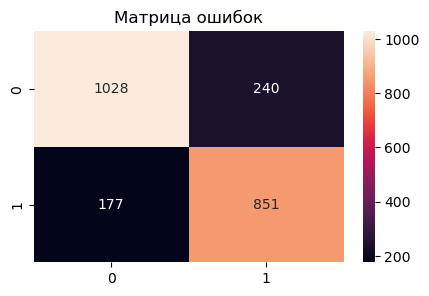

True negative = 1028
False positive = 240
False negative = 177
True positive = 851


Accuracy train    81.80%
Accuracy test     81.84%
Precision         78.00%
Recall            82.78%
F1                80.32%
ROC-AUC           89.39%
dtype: object

In [20]:
model_report(LogisticRegression(class_weight='balanced'))

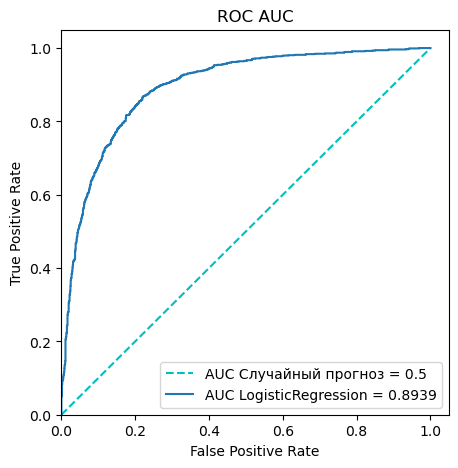

In [21]:
plt.figure(figsize = (5,5), linewidth= 1)
plt.title('ROC AUC')
plt.plot([0, 1], [0, 1],'c--', label = 'AUC Случайный прогноз = 0.5') # Задаем лининию случайного AUC=0.5 как диагональ
res = make_prediction(LogisticRegression(class_weight='balanced'), data, 'sex')
plt.plot(res[-3], res[-2], label = f'AUC LogisticRegression = {res[-1]:.4f}')
plt.legend(loc = 'lower right')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate', size=10)
plt.xlabel('False Positive Rate', size=10)
plt.show()

#### 5. Ручной подсчет метрик TPR, FPR

In [22]:
res = make_prediction(LogisticRegression(class_weight='balanced'), data, 'sex')

In [23]:
thresholds = np.linspace(0, 1, 100)
fpr_manually = []
tpr_manually = []
pr_manually = []
re_manually = []
for threshold in thresholds:
    tp, fp, fn, tn = 0, 0, 0, 0
    for predicted_prob, actual in zip(list(res[2]), res[0].to_list()):
        predicted = 1 if predicted_prob >= threshold else 0
        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    try:
        precision = tp/(tp + fp)
    except:
        precision = 0
    recall = tpr
    fpr_manually.append(fpr)
    tpr_manually.append(tpr)
    pr_manually.append(precision)
    re_manually.append(recall)

Соединяем вектор с фактическими значениями и вероятностями целевого класса приведенными к __0__ или __1__ (в зависимости от порога). Что получилось переводим в серию, ну и т.д.

In [24]:
metricas = pd.Series(zip(
    np.where(res[2] >= 0.5, 1, 0),
    res[0].to_list())).map({(1, 1):'tp', 
                            (0, 0):'tn',
                            (1, 0):'fn',
                            (0, 1):'fp'}
                            ).value_counts()

In [25]:
metricas

tn    1028
tp     851
fn     240
fp     177
dtype: int64

In [26]:
print(f"TPR: {metricas['tp'] / (metricas['tp'] + metricas['fn']):.2f}")
print(f"FPR: {metricas['fp'] / (metricas['fp'] + metricas['tn']):.2f}")

TPR: 0.78
FPR: 0.15


#### 6. График ROC кривой на ручных метриках

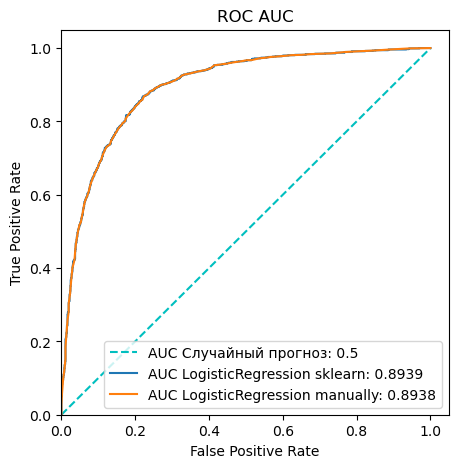

In [27]:
plt.figure(figsize = (5,5), linewidth= 1)
plt.title('ROC AUC')
plt.plot([0, 1], [0, 1],'c--', label = f'AUC Случайный прогноз: 0.5') # Задаем лининию случайного AUC=0.5 как диагональ
res = make_prediction(LogisticRegression(class_weight='balanced'), data, 'sex')
plt.plot(res[-3], res[-2], label = f'AUC LogisticRegression sklearn: {res[-1]:.4f}')
plt.plot(fpr_manually, tpr_manually, label = f'AUC LogisticRegression manually: {auc(fpr_manually, tpr_manually):.4f}')
plt.legend(loc = 'lower right')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate', size=10)
plt.xlabel('False Positive Rate', size=10)
plt.show()

#### 7. График Precision-Recall на ручных метриках

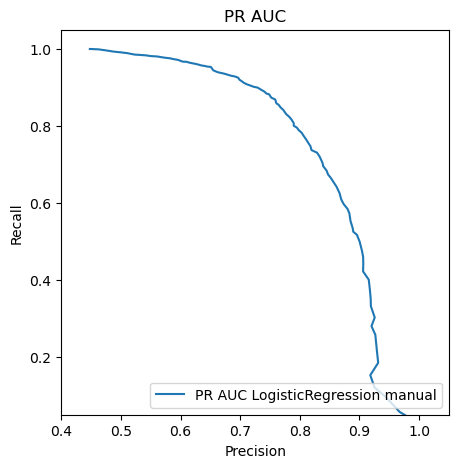

In [28]:
plt.figure(figsize = (5,5), linewidth= 1)
plt.title('PR AUC')
plt.plot(pr_manually, re_manually, label = 'PR AUC LogisticRegression manual')
plt.legend(loc = 'lower right')
plt.xlim([0.4, 1.05])
plt.ylim([0.05, 1.05])
plt.ylabel('Recall', size=10)
plt.xlabel('Precision', size=10)
plt.show()